In [2]:
%matplotlib inline
import torch
from torch.nn import Module,Conv2d,MaxPool2d,ReLU,Sequential,Linear
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn.functional as functional
import os
import PIL
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.optim as optim

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
class LoadDataset():
  def __init__(self,imageFolder,transform=None):
    self.imageFolder = imageFolder
    self.transform = transform

  def __getitem__(self,index):

    image = random.choice(self.imageFolder.imgs)
    random_image1 = random.choice(self.imageFolder.imgs)
    random_image2 = random.choice(self.imageFolder.imgs)


    while(random_image1[1] != image[1]):
      random_image1 = random.choice(self.imageFolder.imgs)

    while(random_image2[1] == image[1]):
      random_image2 = random.choice(self.imageFolder.imgs)

    image = PIL.Image.open(image[0])
    random_image1 = PIL.Image.open(random_image1[0])
    random_image2 = PIL.Image.open(random_image2[0])

#    print(random_image1.shape)



    image = image.convert("L")
    random_image1 = random_image1.convert("L")
    random_image2 = random_image2.convert("L")

    if(self.transform):
      image = self.transform(image)
      random_image1 = self.transform(random_image1)
      random_image2 = self.transform(random_image2)

    return (image,random_image1,torch.from_numpy(np.array(0,dtype = np.float32))),(image,random_image2,torch.from_numpy(np.array(1,dtype = np.float32)))

  def __len__(self):
    return len(self.imageFolder.imgs)




In [3]:
%cd /content/drive/MyDrive/Internship

/content/drive/MyDrive/Internship


In [5]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


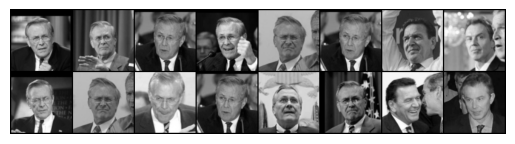

[0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
Siamese_DataLoader = ImageFolder(root = "anchors")
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((100,100)),
  torchvision.transforms.ToTensor()])

Siamese_Dataset = LoadDataset(imageFolder=Siamese_DataLoader,transform=transformations)
visualize_data = DataLoader(Siamese_Dataset,shuffle=True,batch_size=8)
batch = next(iter(visualize_data))
concatenated_Images = torch.cat((batch[0][0],batch[0][1]),0)
imshow(torchvision.utils.make_grid(concatenated_Images))
print(batch[0][2].numpy().reshape(-1))

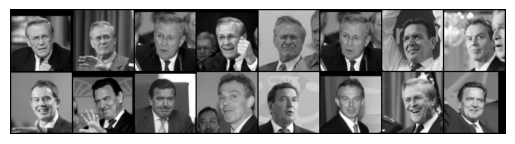

[1. 1. 1. 1. 1. 1. 1. 1.]


In [7]:
concatenated_Images = torch.cat((batch[1][0],batch[1][1]),0)
imshow(torchvision.utils.make_grid(concatenated_Images))
print(batch[1][2].numpy().reshape(-1))

In [8]:
class Siamese_Network(Module):

  def __init__(self):
    super(Siamese_Network,self).__init__()

    self.cnn = Sequential(
            Conv2d(1, 96, kernel_size=11,stride=4),
            ReLU(inplace=True),
            MaxPool2d(3, stride=2),

            Conv2d(96, 256, kernel_size=5, stride=1),
            ReLU(inplace=True),
            MaxPool2d(2, stride=2),

            Conv2d(256, 384, kernel_size=3,stride=1),
            ReLU(inplace=True)
    )

    self.connected = Sequential(
            Linear(384, 1024),
            ReLU(inplace=True),

            Linear(1024, 256),
            ReLU(inplace=True),

            Linear(256,3)
    )

  def forward_once(self,input):
    output = self.cnn(input)
    output = self.connected(output.view(output.size()[0],-1))
    return output

  def forward(self,anchor,positive):
    output_anchor = self.forward_once(anchor)
    output_positive = self.forward_once(positive)
    return output_anchor,output_positive



In [9]:
class TripletLoss(Module):
  def __init__(self,margin=2.0):
    super(TripletLoss,self).__init__()
    self.margin = margin

  def forward(self,anchor,positive,negative):
    res = torch.clamp(functional.pairwise_distance(anchor,positive)-functional.pairwise_distance(anchor,negative)+self.margin,min=0.0)
    return res


In [10]:
Siamese_Model = Siamese_Network()
adam = optim.Adam(Siamese_Model.parameters(),lr=0.0005)
Triplet_Loss = TripletLoss()
Siamese_Dataset = LoadDataset(imageFolder=Siamese_DataLoader,transform=transformations)
Train_data = DataLoader(Siamese_Dataset,shuffle=True,batch_size=24)

Epoch number 0
 Current loss 2.000006914138794

Epoch number 0
 Current loss 2.0007784366607666

Epoch number 1
 Current loss 2.0031023025512695

Epoch number 1
 Current loss 1.9979056119918823

Epoch number 2
 Current loss 2.0003788471221924

Epoch number 2
 Current loss 1.9725009202957153

Epoch number 3
 Current loss 1.9923733472824097

Epoch number 3
 Current loss 1.9065378904342651

Epoch number 4
 Current loss 1.9501785039901733

Epoch number 4
 Current loss 2.0209171772003174

Epoch number 5
 Current loss 2.310614824295044

Epoch number 5
 Current loss 2.023831844329834

Epoch number 6
 Current loss 1.9588083028793335

Epoch number 6
 Current loss 2.0183050632476807

Epoch number 7
 Current loss 2.00774884223938

Epoch number 7
 Current loss 1.9685306549072266

Epoch number 8
 Current loss 1.9465280771255493

Epoch number 8
 Current loss 1.7632070779800415

Epoch number 9
 Current loss 1.654253602027893

Epoch number 9
 Current loss 1.8604241609573364

Epoch number 10
 Current l

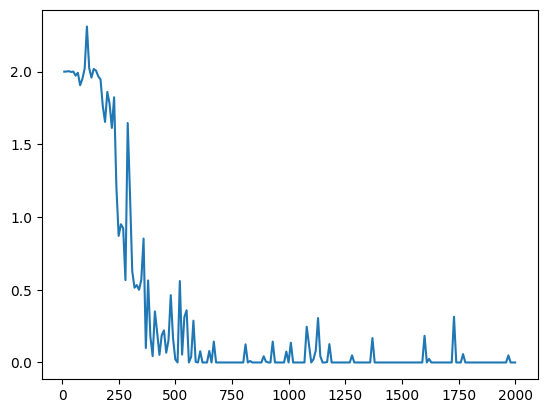

In [11]:
counter = []
loss_history = []
iteration_number= 0
for i in range(100):
  for j,batch in enumerate(Train_data,0):



    adam.zero_grad()
    anchor = batch[0][0]
    positive = batch[0][1]
    positive_label = batch[0][2]

    negative = batch[1][1]
    negative_label = batch[1][2]



    y_anchor,y_positive, = Siamese_Model(anchor,positive)
    _,y_negative = Siamese_Model(anchor,negative)
    TripletLoss = Triplet_Loss(y_anchor,y_positive,y_negative)
    TripletLoss.mean().backward()
    adam.step()

    if j % 10 == 0 :
            print(f"Epoch number {i}\n Current loss {TripletLoss.mean().item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(TripletLoss.mean().item())

show_plot(counter, loss_history)



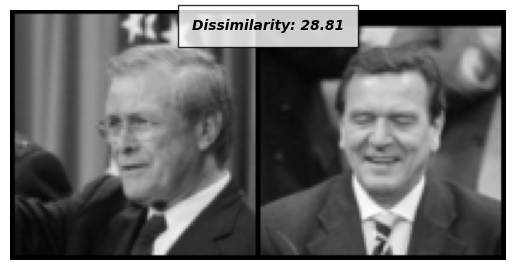

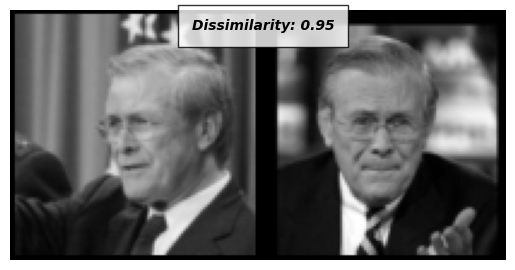

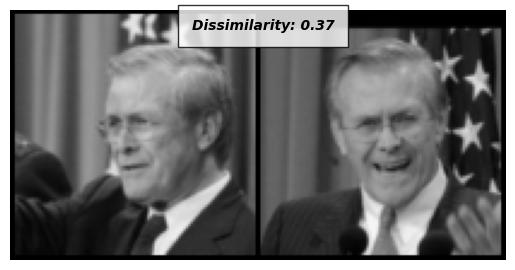

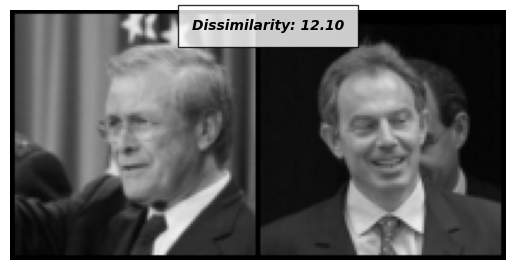

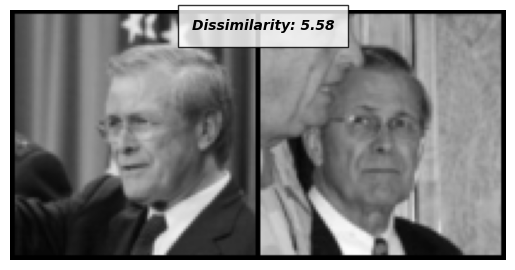

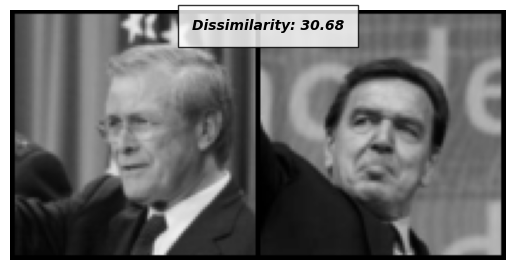

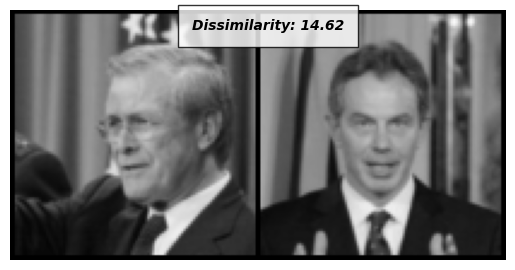

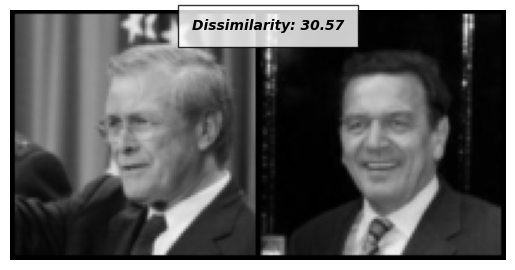

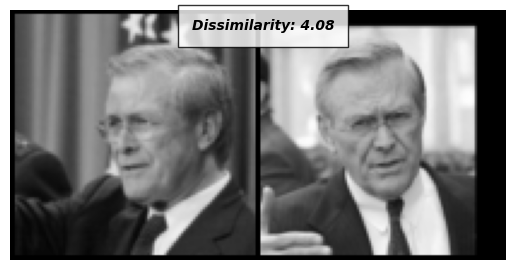

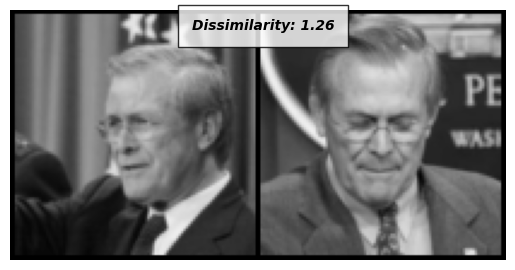

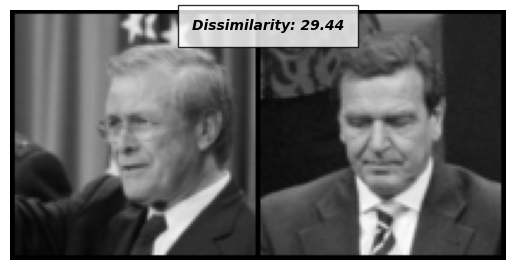

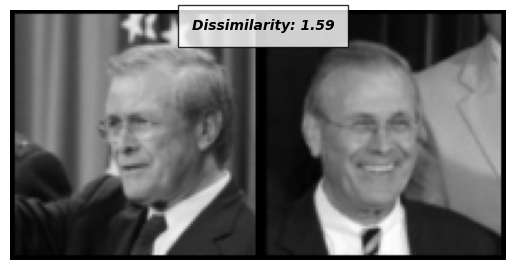

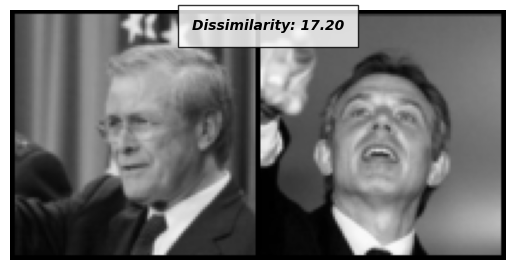

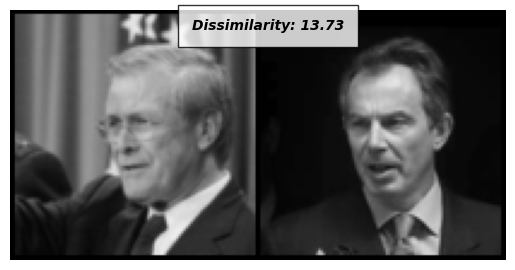

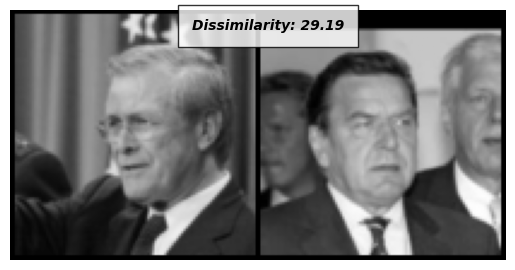

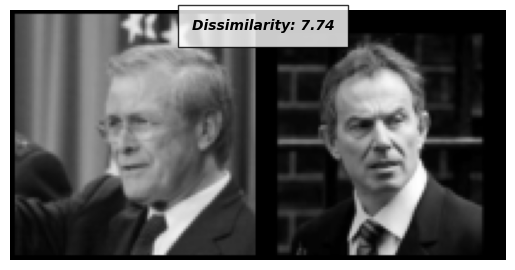

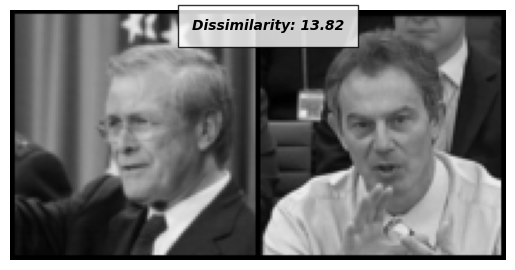

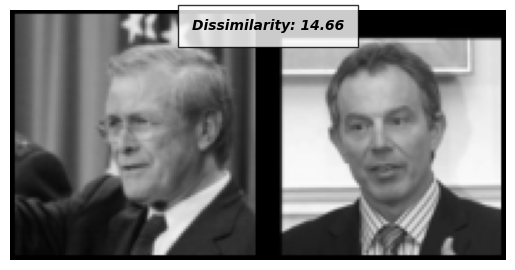

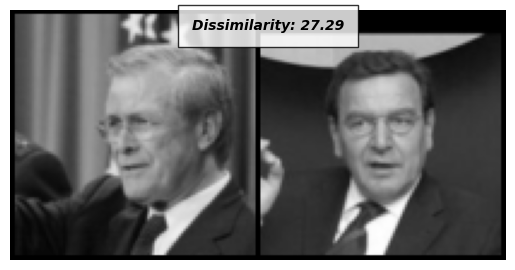

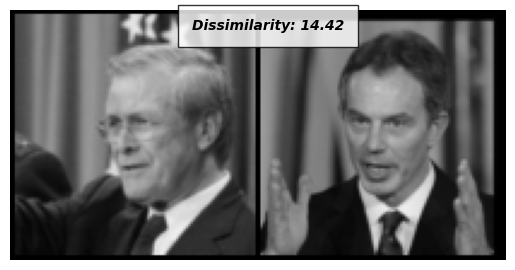

In [13]:
folder_dataset_test = ImageFolder(root="positives")
siamese_dataset = LoadDataset(imageFolder=folder_dataset_test,transform=transformations)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0 = next(dataiter)
#print(x0,x1,x2)

for i in range(20):
    x1 = next(dataiter)

    concatenated = torch.cat((x0[0][0], x1[0][0]), 0)

    output1, output2 = Siamese_Model(x0[0][0], x1[0][0])
    euclidean_distance = functional.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

In [16]:
model_scripted = torch.jit.script(Siamese_Model)
model_scripted.save('TripletLoss.pt')